In [1]:
# !pip install datasets

In [2]:
# !pip install scikit-learn

# Import modules

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC

In [4]:
from datasets import load_dataset

dataset = load_dataset("imodels/diabetes-readmission")
df = pd.DataFrame(dataset["train"])
X = df.drop(columns=["readmitted"])
y = df["readmitted"].values

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,change,diabetesMed,...,glyburide-metformin:Up,A1Cresult:>7,A1Cresult:>8,A1Cresult:None,A1Cresult:Norm,max_glu_serum:>200,max_glu_serum:>300,max_glu_serum:None,max_glu_serum:Norm,readmitted
0,2.0,38.0,3.0,27.0,0.0,1.0,2.0,7.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
1,4.0,48.0,0.0,11.0,0.0,0.0,0.0,9.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
2,2.0,28.0,0.0,15.0,0.0,3.0,4.0,9.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
3,4.0,44.0,0.0,10.0,0.0,0.0,0.0,7.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0
4,3.0,54.0,0.0,8.0,0.0,0.0,0.0,8.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0


In [8]:
df.shape

(81410, 151)

In [9]:
print(df.columns)

Index(['time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'change', 'diabetesMed',
       ...
       'glyburide-metformin:Up', 'A1Cresult:>7', 'A1Cresult:>8',
       'A1Cresult:None', 'A1Cresult:Norm', 'max_glu_serum:>200',
       'max_glu_serum:>300', 'max_glu_serum:None', 'max_glu_serum:Norm',
       'readmitted'],
      dtype='object', length=151)


# EDA

In [10]:
df.isna().sum()

,0
time_in_hospital,0
num_lab_procedures,0
num_procedures,0
num_medications,0
number_outpatient,0
...,...
max_glu_serum:>200,0
max_glu_serum:>300,0
max_glu_serum:None,0
max_glu_serum:Norm,0


In [31]:
# Check for class imbalance

# pd.DataFrame(dataset['train'])['readmitted'].value_counts()

In [5]:
# pd.DataFrame(dataset['test'])['readmitted'].value_counts()

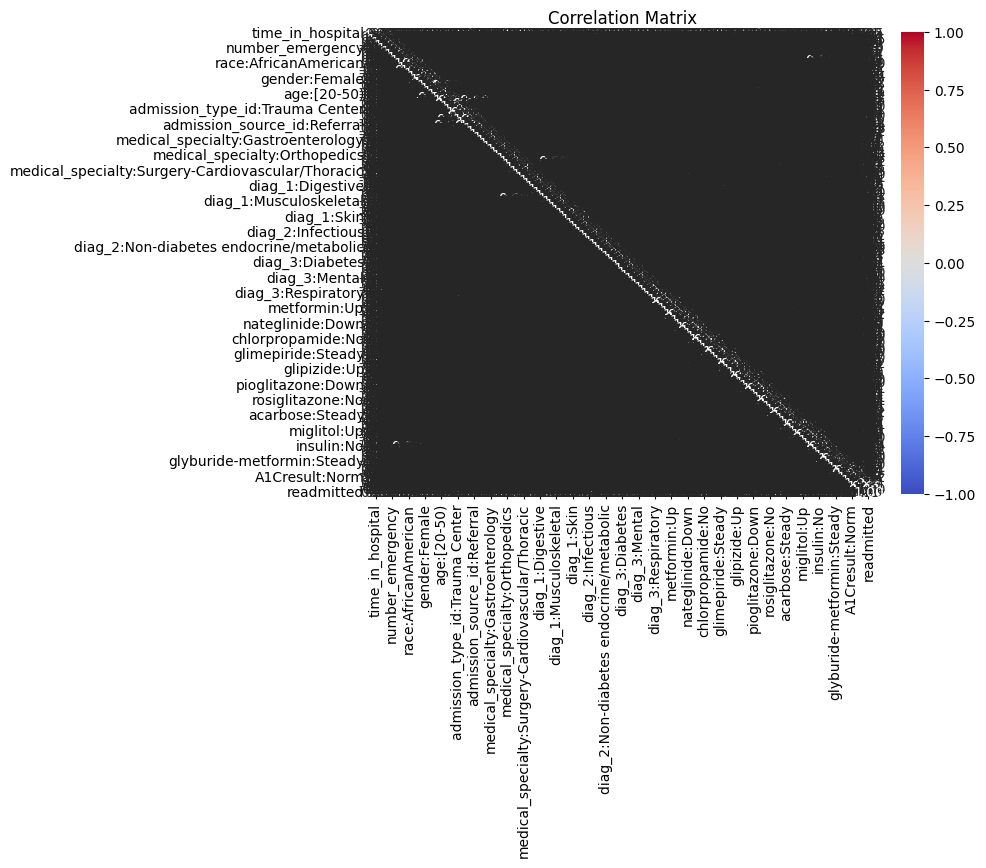

In [12]:
# Get numerical correlation matrix
correlation_matrix = df.corr()

# Visualize correlation heat map
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

# Model Training

In [13]:
X = df.drop(columns=["readmitted"])
y = df["readmitted"]

In [14]:
# Split off 40% for production data
X_train_val_test, X_prod, y_train_val_test, y_prod = train_test_split(
    X, y, test_size=0.4, random_state=42
)

# Split the remaining 60% into 40% train, 10% validation, and 10% test
# First, split into 2/3 train and 1/3 val+test (which is 40% train of the original)
X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_train_val_test, y_train_val_test, test_size=1 / 3, random_state=42
)

# Then, split the remaining val+test (20% of the original) into 50% val and 50% test
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.5, random_state=42
)

In [15]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## Feature importance - PCA

In [16]:
# Apply PCA on the standardized training features
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)

# Transform the test data using the already-fitted PCA
X_test_pca = pca.transform(X_test_scaled)

# Print the explained variance ratio to understand importance of components
explained_variance_ratio = pca.explained_variance_ratio_
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: [2.58852794e-02 2.34768012e-02 2.05630644e-02 1.75321431e-02
 1.68721119e-02 1.53979625e-02 1.51599947e-02 1.47411468e-02
 1.45977855e-02 1.42309302e-02 1.40173345e-02 1.37490134e-02
 1.37096456e-02 1.36398164e-02 1.36193317e-02 1.35691297e-02
 1.31127051e-02 1.29977660e-02 1.27302617e-02 1.20839998e-02
 1.16971172e-02 1.16448137e-02 1.13217951e-02 1.07741478e-02
 1.01798593e-02 1.01015937e-02 9.77708862e-03 9.73377468e-03
 9.58512927e-03 9.35189143e-03 9.25463757e-03 9.07203135e-03
 8.80466843e-03 8.61358090e-03 8.59296130e-03 8.26553240e-03
 8.05341068e-03 7.93154521e-03 7.90522023e-03 7.81446423e-03
 7.77320014e-03 7.65333621e-03 7.63505700e-03 7.59125463e-03
 7.51191434e-03 7.44025664e-03 7.37501403e-03 7.31964990e-03
 7.28766058e-03 7.26500945e-03 7.20816560e-03 7.18369517e-03
 7.13907671e-03 7.11167542e-03 7.08022386e-03 7.04912414e-03
 7.03237219e-03 7.02015395e-03 7.00540259e-03 6.97950105e-03
 6.96918519e-03 6.92924485e-03 6.88677049e-03 6.87698696e-0

In [27]:
# Build the neural network
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(16, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

# Compile the model (using binary cross-entropy for binary classification)
model.compile(
    optimizer=AdamW(learning_rate=0.0001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Define early stopping
early_stopping = EarlyStopping(
    monitor="val_loss", patience=15, restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_pca,
    y_train,
    validation_data=(X_val_pca, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.4954 - loss: 0.7700 - val_accuracy: 0.5278 - val_loss: 0.6934
Epoch 2/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5177 - loss: 0.7128 - val_accuracy: 0.5287 - val_loss: 0.6922
Epoch 3/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5260 - loss: 0.6995 - val_accuracy: 0.5306 - val_loss: 0.6916
Epoch 4/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5251 - loss: 0.6962 - val_accuracy: 0.5287 - val_loss: 0.6914
Epoch 5/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5231 - loss: 0.6974 - val_accuracy: 0.5298 - val_loss: 0.6910
Epoch 6/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5313 - loss: 0.6941 - val_accuracy: 0.5294 - val_loss: 0.6911
Epoch 7/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5337 - loss: 0.6917 - val_accuracy: 0.5293 - val_loss: 0.6908
Epoch 8/100
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5352 - loss: 0.6917 - val_

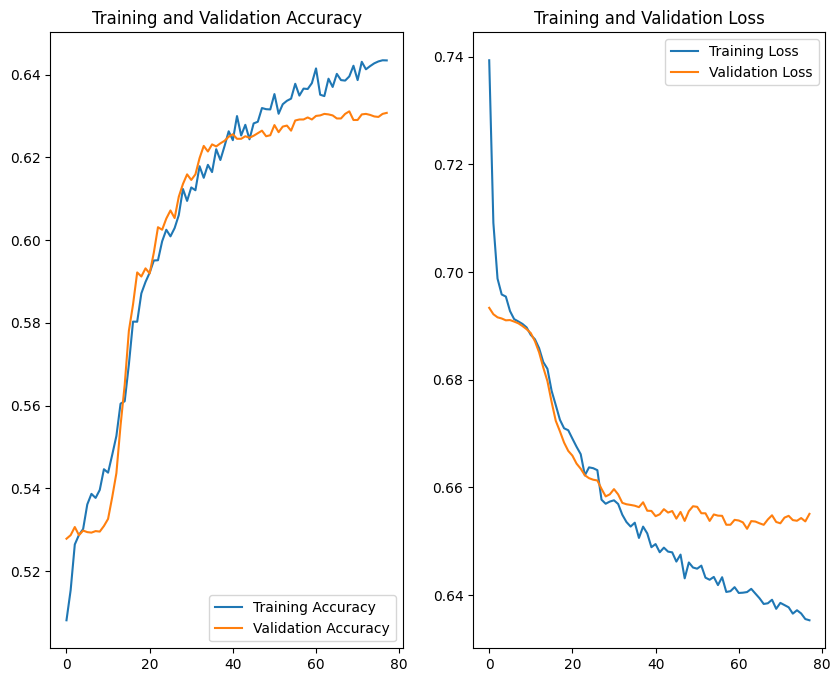

In [28]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(len(acc))

plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

# Model Prediction



In [29]:
# 6. Evaluate the model on the test data
y_test_pred = (model.predict(X_test_pca) > 0.5).astype(
    "int32"
)  # Since the output is probability, we convert it to 0 or 1
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy}")

# Print classification report
print(classification_report(y_test, y_test_pred))

255/255 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Test Accuracy: 0.6296523768578799
              precision    recall  f1-score   support

           0       0.63      0.75      0.69      4387
           1       0.63      0.49      0.55      3754

    accuracy                           0.63      8141
   macro avg       0.63      0.62      0.62      8141
weighted avg       0.63      0.63      0.62      8141



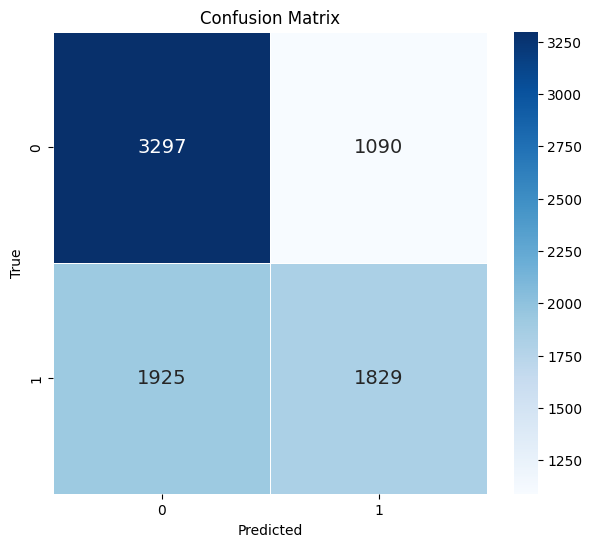

<Figure size 1000x800 with 0 Axes>

In [30]:
# Compute confusion matrix
cmatrix_lstm = confusion_matrix(y_test, y_test_pred)
fontsize = 7
figsize = (7, 6)  # Increased figure size for better readability
fig, ax = plt.subplots(figsize=figsize)
plt.figure(figsize=(10, 8))
cmap = plt.colormaps.get_cmap("Blues")

# Create the confusion matrix heatmap
sns.heatmap(
    cmatrix_lstm,
    annot=True,
    cmap=cmap,
    cbar=True,
    ax=ax,
    linewidths=0.5,
    fmt="d",
    annot_kws={"fontsize": 14},
)

# Set labels and title
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")
plt.show()